# Charger les bibliothèques


In [1]:
#Import libraries for data treatment
import numpy as np
from numpy import expand_dims
import pandas as pd

# Import Tensorflow
import tensorflow as tf

# Keras tools
from tensorflow import keras


# Keras image augmentation tools
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

#Import libraries for visualisation
import IPython.display as display
import PIL
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
%matplotlib inline

#Import tools for files operations 
import joblib
import sys
import os
from os import listdir
import tarfile
import shutil
import pathlib


# Libraries for time measure
import time

Using TensorFlow backend.


In [3]:
# Check the Tensorflow version
tf.__version__

'2.0.0'

# Importer et formater les données

Les données étaient préalablement téléchargées depuis le site http://vision.stanford.edu/aditya86/ImageNetDogs/ et enregistrées dans le dossier 'Data'.

In [ ]:
def file_create(path):
    """ Function which will create directories if they do not already exist"""
    if  not os.path.exists(path):
        os.mkdir(path)

In [ ]:
%cd C:\Users\Utilisateur\Documents\Formations\Openclassrooms\PROJET6\Data

Nous allons créer des dossiers pour extraire les fichiers de données :

In [ ]:
file_create('train')
file_create('test')
file_create('redim')
file_create('redim/train')
file_create('redim/test')

La fonction suivante a pour le but extraire les fichiers (s'il n'existent pas déjà) :

In [ ]:
def maybe_extract(filename, check_classes=True, force=False):
    
    """Function to extract the compressed data"""
    
    root = os.path.splitext(filename)[0]  # remove .tar
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    if check_classes:
        data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
        if len(data_folders) != num_classes:
            raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
        print('Completed extraction of %s.' % filename)
        return data_folders
    else:
        print('Completed extraction of %s.' % filename)

In [ ]:
data_root = '.'
num_classes = 120
image_size = 224
num_channels = 3
np.random.seed(133)
images_filename = 'images.tar'
annotation_filename = 'annotation.tar'
lists_filename = 'lists.tar'

In [ ]:
images_folders = maybe_extract(images_filename)
annotation_folders = maybe_extract(annotation_filename)
maybe_extract(lists_filename, check_classes=False)

In [ ]:
# Creating subdirectories in train / test & redim directories

for folder in images_folders:
    os.makedirs("train/"+folder.split("\\")[-1])
    os.makedirs("test/"+folder.split("\\")[-1])
    os.makedirs("redim/train/"+folder.split("\\")[-1])
    os.makedirs("redim/test/"+folder.split("\\")[-1])

In [ ]:
def move_data_files(image_list, new_folder):
    
    """Fonction which moves the files in a new directories based upon the list of files.
    
    Args :
    
    - image_list : a list of images
    - new_folder : a string with a name of new folder
    
    Returns a list of new folders.
    """
    
    for file in image_list:
        if os.path.exists('Images/'+file[0][0]):
            shutil.move('Images/'+file[0][0],new_folder+'/'+file[0][0])
        elif not os.path.exists(new_folder+'/'+file[0][0]):
             print('%s does not exist, it may be missing' % os.path.exists('./images/'+file[0][0]))
    return [new_folder+'/'+d for d in sorted(os.listdir(new_folder)) if os.path.isdir(os.path.join(new_folder, d))]

In [ ]:
# Move test files to directory test and train files to directory train. 
# Create a list of new folders

test_folders = move_data_files(test_list, 'redim/test')
train_folders = move_data_files(train_list, 'redim/train')

Nous allons travailler sur les données rédimensionnées qui seront aussi téléversés sur Google drive pour que nous puissions les lire avec Google colab, ainsi que sur l'instance de Sagemaker.

In [1]:
%cd Data/redim/

C:\Users\Utilisateur\Documents\Formations\Openclassrooms\PROJET6\Data\redim


In [4]:
train_data_dir = pathlib.Path('train')

In [5]:
test_data_dir = pathlib.Path('test')

In [9]:
# Obtain class names

CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])

# Séparer les données de validation

In [36]:
# Create the validation directory + subdirectories
file_create('valid')
for folder in CLASS_NAMES:
    name = 'valid/' + str(folder)
    file_create(name)

In [8]:
valid_data_dir = pathlib.Path('valid')

In [22]:
# Check the min number of photos in test folder
len_dir = []
for folder in CLASS_NAMES:
    name = 'test/' + str(folder)
    length = len(listdir(name))
    len_dir.append(length)
min(len_dir)

48

In [39]:
for folder in CLASS_NAMES:
    for i in range(24):
       
        name1 = 'test/' + str(folder)
        name2 = 'valid/' + str(folder)
        filename1 = name1 + '/' + str(listdir(name1)[i])
        filename2 = name2 + '/' + str(listdir(name1)[i])
        if not os.path.exists(filename2):
            shutil.move(filename1, filename2)

# Créer les générateurs

In [9]:
# Calculate the data size
train_size = len(list(train_data_dir.glob('*/*.jpg')))
valid_size = len(list(valid_data_dir.glob('*/*.jpg')))
test_size = len(list(test_data_dir.glob('*/*.jpg')))
print("Number of train photos : " + str(train_size))
print("Number of validation photos : " + str(valid_size))
print("Number of test photos : " + str(test_size))

Number of train photos : 12000
Number of validation photos : 2880
Number of test photos : 5700


In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_generator = ImageDataGenerator(rescale=1./255)

In [11]:
batch_size = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [13]:
# Generator for batch visualisation
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES)
                                                     )

Found 12000 images belonging to 120 classes.


In [44]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(20):
        ax = plt.subplot(5,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

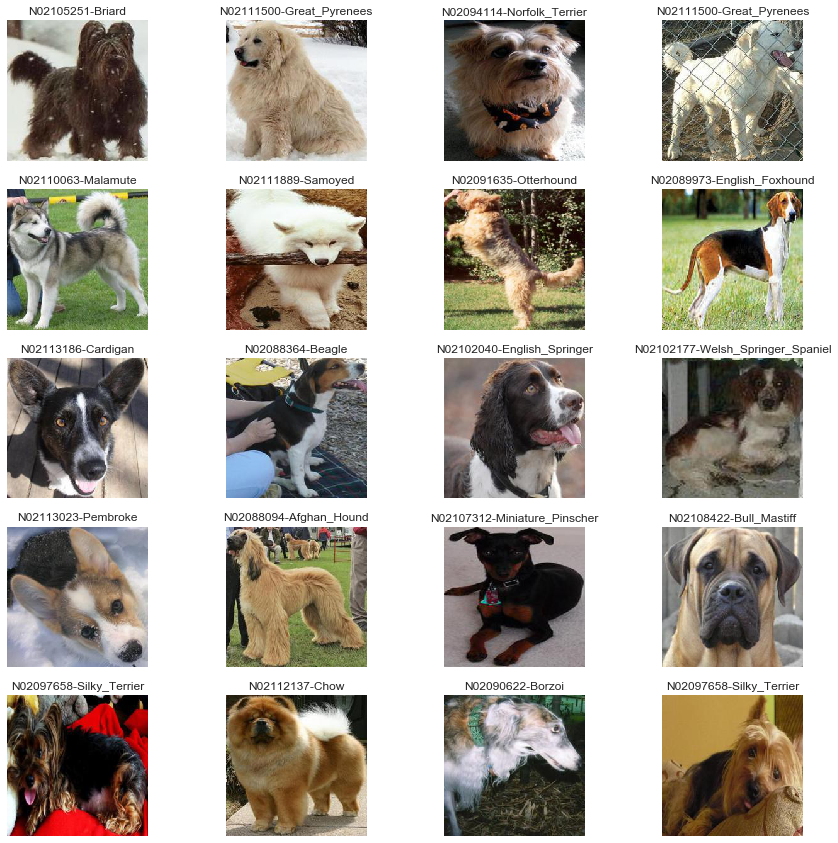

In [45]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [12]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), 
                                                     class_mode="sparse"
                                                     )

Found 12000 images belonging to 120 classes.


In [19]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [20]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 2880 images belonging to 120 classes.


In [21]:
test_data_gen = test_generator.flow_from_directory(directory=str(test_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 5700 images belonging to 120 classes.


# Modèle CNN from scratch

## CNN 1 - Données sans Augmentation

### CNN 1 A - Batch = 20 TEST de performance

In [2]:
%cd Data/best_breeds_redim

C:\Users\Utilisateur\Documents\Formations\Openclassrooms\PROJET6\Data\best_breeds_redim


In [3]:
train_data_dir = pathlib.Path('train')
test_data_dir = pathlib.Path('test')
valid_data_dir = pathlib.Path('valid')

In [4]:
# Calculate the data size
train_size = len(list(train_data_dir.glob('*/*.jpg')))
valid_size = len(list(valid_data_dir.glob('*/*.jpg')))
test_size = len(list(test_data_dir.glob('*/*.jpg')))
print("Number of train photos : " + str(train_size))
print("Number of validation photos : " + str(valid_size))
print("Number of test photos : " + str(test_size))

Number of train photos : 500
Number of validation photos : 125
Number of test photos : 164


In [5]:
# Obtain class names

CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])

In [6]:
batch_size = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [7]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), 
                                                     class_mode="sparse"
                                                     )

Found 500 images belonging to 5 classes.


In [9]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [10]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 125 images belonging to 5 classes.


In [11]:
my_CNN1 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[224, 224, 3]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=2),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])
my_CNN1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [12]:
# Compile the modele 
my_CNN1.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN1.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    #callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time))) + " sec " )

Epoch 1/10
25/25 [==============================] - 17s 665ms/step - loss: 1.6112 - accuracy: 0.2000 - val_loss: 1.6111 - val_accuracy: 0.2000
Epoch 2/10
25/25 [==============================] - 18s 724ms/step - loss: 1.6109 - accuracy: 0.2000 - val_loss: 1.6103 - val_accuracy: 0.2000
Epoch 3/10
25/25 [==============================] - 17s 671ms/step - loss: 1.6106 - accuracy: 0.2000 - val_loss: 1.6082 - val_accuracy: 0.2000
Epoch 4/10
25/25 [==============================] - 17s 668ms/step - loss: 1.6102 - accuracy: 0.2000 - val_loss: 1.6115 - val_accuracy: 0.2000
Epoch 5/10
25/25 [==============================] - 17s 675ms/step - loss: 1.6098 - accuracy: 0.2000 - val_loss: 1.6110 - val_accuracy: 0.2000
Epoch 6/10
25/25 [==============================] - 17s 678ms/step - loss: 1.6095 - accuracy: 0.2000 - val_loss: 1.6108 - val_accuracy: 0.2000
Epoch 7/10
25/25 [==============================] - 16s 655ms/step - loss: 1.6091 - accuracy: 0.2000 - val_loss: 1.6104 - val_accuracy: 0.2000

## CNN 1 A - Batch = 20

In [26]:
my_CNN1 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[224, 224, 3]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=2),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(120, activation="softmax")
])
my_CNN1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [27]:
# Compile the modele 
my_CNN1.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN1A_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN1A_run_2019_12_30-09_37_34'

In [58]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN1A.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [59]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN1.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
600/600 [==============================] - 404s 674ms/step - loss: 4.7876 - accuracy: 0.0078 - val_loss: 4.7874 - val_accuracy: 0.0087
Epoch 2/10
600/600 [==============================] - 368s 613ms/step - loss: 4.7874 - accuracy: 0.0087 - val_loss: 4.7873 - val_accuracy: 0.0097
Epoch 3/10
600/600 [==============================] - 365s 608ms/step - loss: 4.7873 - accuracy: 0.0091 - val_loss: 4.7871 - val_accuracy: 0.0097
Epoch 4/10
600/600 [==============================] - 360s 600ms/step - loss: 4.7872 - accuracy: 0.0090 - val_loss: 4.7870 - val_accuracy: 0.0101
Epoch 5/10
600/600 [==============================] - 361s 601ms/step - loss: 4.7871 - accuracy: 0.0092 - val_loss: 4.7869 - val_accuracy: 0.0097
Epoch 6/10
600/600 [==============================] - 359s 599ms/step - loss: 4.7869 - accuracy: 0.0093 - val_loss: 4.7868 - val_accuracy: 0.0094
Epoch 7/10
600/600 [==============================] - 359s 599ms/step - loss: 4.7868 - accuracy: 0.0093 - val_loss: 4.7867 -

In [13]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 1732), started 3 days, 23:32:30 ago. (Use '!kill 1732' to kill it.)

In [60]:
# Evaluate the model on test data
my_CNN1.load_weights('my_CNN1A.h5')

my_CNN1.evaluate(test_data_gen)

285/285 [==============================] - 57s 200ms/step - loss: 4.7861 - accuracy: 0.0149


[4.786075083414714, 0.01491228]

## CNN 1 B - Batch = 30

In [26]:
batch_size = 30 # Batch size changed 20 -> 30
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [27]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_generator = ImageDataGenerator(rescale=1./255)

In [28]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), 
                                                     class_mode="sparse"
                                                     )

Found 12000 images belonging to 120 classes.


In [29]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [30]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 2880 images belonging to 120 classes.


In [31]:
test_data_gen = test_generator.flow_from_directory(directory=str(test_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 5700 images belonging to 120 classes.


In [32]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN1B_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN1B_run_2019_12_30-17_00_53'

In [33]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN1B.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [34]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10


# Train the model
my_CNN1.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
400/400 [==============================] - 362s 904ms/step - loss: 4.7875 - accuracy: 0.0085 - val_loss: 4.7875 - val_accuracy: 0.0087
Epoch 2/10
400/400 [==============================] - 360s 899ms/step - loss: 4.7874 - accuracy: 0.0088 - val_loss: 4.7874 - val_accuracy: 0.0090
Epoch 3/10
400/400 [==============================] - 360s 899ms/step - loss: 4.7873 - accuracy: 0.0077 - val_loss: 4.7874 - val_accuracy: 0.0090
Epoch 4/10
400/400 [==============================] - 370s 926ms/step - loss: 4.7872 - accuracy: 0.0080 - val_loss: 4.7873 - val_accuracy: 0.0083
Epoch 5/10
400/400 [==============================] - 363s 908ms/step - loss: 4.7871 - accuracy: 0.0087 - val_loss: 4.7872 - val_accuracy: 0.0080
Epoch 6/10
400/400 [==============================] - 364s 909ms/step - loss: 4.7870 - accuracy: 0.0075 - val_loss: 4.7872 - val_accuracy: 0.0083
Epoch 7/10
400/400 [==============================] - 362s 904ms/step - loss: 4.7870 - accuracy: 0.0077 - val_loss: 4.7871 -

In [35]:
# Evaluate the model on test data
my_CNN1.load_weights('my_CNN1B.h5')

my_CNN1.evaluate(test_data_gen)

190/190 [==============================] - 37s 195ms/step - loss: 4.7871 - accuracy: 0.0102


[4.787101652747706, 0.010175439]

## CNN 1 C - Batch = 40

In [36]:
batch_size = 40 # Batch size changed 20 -> 40
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [37]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_generator = ImageDataGenerator(rescale=1./255)

In [38]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), 
                                                     class_mode="sparse"
                                                     )

Found 12000 images belonging to 120 classes.


In [39]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [40]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 2880 images belonging to 120 classes.


In [41]:
test_data_gen = test_generator.flow_from_directory(directory=str(test_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 5700 images belonging to 120 classes.


In [42]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN1C_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN1C_run_2019_12_30-18_02_25'

In [43]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN1C.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [44]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN1.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
300/300 [==============================] - 353s 1s/step - loss: 4.7866 - accuracy: 0.0077 - val_loss: 4.7868 - val_accuracy: 0.0083
Epoch 2/10
300/300 [==============================] - 356s 1s/step - loss: 4.7865 - accuracy: 0.0077 - val_loss: 4.7867 - val_accuracy: 0.0083
Epoch 3/10
300/300 [==============================] - 354s 1s/step - loss: 4.7864 - accuracy: 0.0074 - val_loss: 4.7867 - val_accuracy: 0.0073
Epoch 4/10
300/300 [==============================] - 354s 1s/step - loss: 4.7864 - accuracy: 0.0075 - val_loss: 4.7866 - val_accuracy: 0.0066
Epoch 5/10
300/300 [==============================] - 352s 1s/step - loss: 4.7863 - accuracy: 0.0075 - val_loss: 4.7865 - val_accuracy: 0.0073
Epoch 6/10
300/300 [==============================] - 345s 1s/step - loss: 4.7862 - accuracy: 0.0080 - val_loss: 4.7864 - val_accuracy: 0.0073
Epoch 7/10
300/300 [==============================] - 347s 1s/step - loss: 4.7861 - accuracy: 0.0082 - val_loss: 4.7864 - val_accuracy: 0.0073

In [45]:
# Evaluate the model on test data
my_CNN1.load_weights('my_CNN1C.h5')

my_CNN1.evaluate(test_data_gen)

143/143 [==============================] - 35s 248ms/step - loss: 4.7864 - accuracy: 0.0114


[4.78643813166585, 0.0114035085]

## CNN 1 D - Batch = 50


In [46]:
batch_size = 50 # Batch size changed 20 -> 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [47]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_generator = ImageDataGenerator(rescale=1./255)

In [48]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), 
                                                     class_mode="sparse"
                                                     )

Found 12000 images belonging to 120 classes.


In [49]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [50]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 2880 images belonging to 120 classes.


In [51]:
test_data_gen = test_generator.flow_from_directory(directory=str(test_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 5700 images belonging to 120 classes.


In [52]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN1D_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN1D_run_2019_12_30-19_05_02'

In [53]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN1D.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [54]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10
batch_size = 50 # Batch size changed 20 -> 50

# Train the model
my_CNN1.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
240/240 [==============================] - 353s 1s/step - loss: 4.7857 - accuracy: 0.0075 - val_loss: 4.7860 - val_accuracy: 0.0069
Epoch 2/10
240/240 [==============================] - 351s 1s/step - loss: 4.7857 - accuracy: 0.0082 - val_loss: 4.7860 - val_accuracy: 0.0073
Epoch 3/10
240/240 [==============================] - 351s 1s/step - loss: 4.7856 - accuracy: 0.0082 - val_loss: 4.7858 - val_accuracy: 0.0080
Epoch 4/10
240/240 [==============================] - 350s 1s/step - loss: 4.7855 - accuracy: 0.0077 - val_loss: 4.7858 - val_accuracy: 0.0080
Epoch 5/10
240/240 [==============================] - 351s 1s/step - loss: 4.7854 - accuracy: 0.0077 - val_loss: 4.7857 - val_accuracy: 0.0087
Epoch 6/10
240/240 [==============================] - 351s 1s/step - loss: 4.7853 - accuracy: 0.0079 - val_loss: 4.7856 - val_accuracy: 0.0094
Epoch 7/10
240/240 [==============================] - 351s 1s/step - loss: 4.7852 - accuracy: 0.0074 - val_loss: 4.7855 - val_accuracy: 0.0094

In [55]:
# Evaluate the model on test data
my_CNN1.load_weights('my_CNN1D.h5')

my_CNN1.evaluate(test_data_gen)

114/114 [==============================] - 34s 296ms/step - loss: 4.7857 - accuracy: 0.0114


[4.785739953057808, 0.0114035085]

## CNN 2 - Données avec Augmentation

In [28]:
batch_size = 20 
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [29]:
# Fit the generator including data augmentation
train_generator = ImageDataGenerator(rescale=1./255, 
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2, 
                                     horizontal_flip=True,
                                     rotation_range=20, 
                                     brightness_range= [0.5, 1.2])

In [30]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                          seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), 
                                                     class_mode="sparse")

Found 12000 images belonging to 120 classes.


In [31]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [32]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 2880 images belonging to 120 classes.


In [33]:
test_data_gen = test_generator.flow_from_directory(directory=str(test_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 5700 images belonging to 120 classes.


In [23]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN2_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN2_2019_12_31-12_19_08'

In [34]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN2.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [35]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN1.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
600/600 [==============================] - 434s 724ms/step - loss: 4.7875 - accuracy: 0.0086 - val_loss: 4.7875 - val_accuracy: 0.0128
Epoch 2/10
600/600 [==============================] - 408s 680ms/step - loss: 4.7874 - accuracy: 0.0088 - val_loss: 4.7874 - val_accuracy: 0.0125
Epoch 3/10
600/600 [==============================] - 408s 679ms/step - loss: 4.7873 - accuracy: 0.0088 - val_loss: 4.7873 - val_accuracy: 0.0108
Epoch 4/10
600/600 [==============================] - 408s 680ms/step - loss: 4.7872 - accuracy: 0.0079 - val_loss: 4.7872 - val_accuracy: 0.0115
Epoch 5/10
600/600 [==============================] - 410s 683ms/step - loss: 4.7871 - accuracy: 0.0079 - val_loss: 4.7871 - val_accuracy: 0.0108
Epoch 6/10
600/600 [==============================] - 414s 690ms/step - loss: 4.7870 - accuracy: 0.0086 - val_loss: 4.7870 - val_accuracy: 0.0115
Epoch 7/10
600/600 [==============================] - 411s 685ms/step - loss: 4.7869 - accuracy: 0.0072 - val_loss: 4.7869 -

In [36]:
# Evaluate the model on test data
my_CNN1.load_weights('my_CNN2.h5')

my_CNN1.evaluate(test_data_gen)

285/285 [==============================] - 56s 196ms/step - loss: 4.7867 - accuracy: 0.0070


[4.78674974274217, 0.007017544]

## CNN 3 - Changement paramètre strides

In [44]:
my_CNN3 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[224, 224, 3]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1), # Changed from 2 -> 1
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(120, activation="softmax")
])
my_CNN3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 256)      

In [45]:
# Compile the modele 
my_CNN3.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN3_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN3_run_2019_12_31-13_34_44'

In [46]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN3.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [47]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN3.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
600/600 [==============================] - 1130s 2s/step - loss: 4.7877 - accuracy: 0.0078 - val_loss: 4.7874 - val_accuracy: 0.0087
Epoch 2/10
600/600 [==============================] - 1132s 2s/step - loss: 4.7875 - accuracy: 0.0077 - val_loss: 4.7872 - val_accuracy: 0.0083
Epoch 3/10
600/600 [==============================] - 1132s 2s/step - loss: 4.7872 - accuracy: 0.0086 - val_loss: 4.7869 - val_accuracy: 0.0083
Epoch 4/10
600/600 [==============================] - 1138s 2s/step - loss: 4.7870 - accuracy: 0.0093 - val_loss: 4.7866 - val_accuracy: 0.0108
Epoch 5/10
600/600 [==============================] - 1131s 2s/step - loss: 4.7867 - accuracy: 0.0093 - val_loss: 4.7864 - val_accuracy: 0.0097
Epoch 6/10
600/600 [==============================] - 1129s 2s/step - loss: 4.7866 - accuracy: 0.0093 - val_loss: 4.7861 - val_accuracy: 0.0104
Epoch 7/10
600/600 [==============================] - 1127s 2s/step - loss: 4.7864 - accuracy: 0.0088 - val_loss: 4.7857 - val_accuracy:

In [48]:
# Evaluate the model on test data
my_CNN3.load_weights('my_CNN3.h5')

my_CNN3.evaluate(test_data_gen)

285/285 [==============================] - 114s 402ms/step - loss: 4.7840 - accuracy: 0.0186


[4.784048590743751, 0.01859649]

## CNN 4 - Réduire le monbre de paramètres et ajouter une couche dropout

In [52]:
my_CNN4 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[224, 224, 3]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1), 
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),    
    #keras.layers.Dense(256, activation="relu"),
    #keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5), # New layer added
    keras.layers.Dense(120, activation="softmax")
])
my_CNN4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 256)      

In [53]:
# Compile the modele 
my_CNN4.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN4_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN4_run_2019_12_31-16_57_21'

In [55]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN4.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [56]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN4.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
600/600 [==============================] - 1125s 2s/step - loss: 4.7876 - accuracy: 0.0093 - val_loss: 4.7869 - val_accuracy: 0.0101
Epoch 2/10
600/600 [==============================] - 1124s 2s/step - loss: 4.7874 - accuracy: 0.0085 - val_loss: 4.7865 - val_accuracy: 0.0083
Epoch 3/10
600/600 [==============================] - 1120s 2s/step - loss: 4.7868 - accuracy: 0.0094 - val_loss: 4.7858 - val_accuracy: 0.0083
Epoch 4/10
600/600 [==============================] - 1122s 2s/step - loss: 4.7866 - accuracy: 0.0095 - val_loss: 4.7855 - val_accuracy: 0.0090
Epoch 5/10
600/600 [==============================] - 1124s 2s/step - loss: 4.7864 - accuracy: 0.0090 - val_loss: 4.7850 - val_accuracy: 0.0111
Epoch 6/10
600/600 [==============================] - 1124s 2s/step - loss: 4.7863 - accuracy: 0.0101 - val_loss: 4.7847 - val_accuracy: 0.0125
Epoch 7/10
600/600 [==============================] - 1125s 2s/step - loss: 4.7859 - accuracy: 0.0093 - val_loss: 4.7843 - val_accuracy:

In [57]:
# Evaluate the model on test data
my_CNN4.load_weights('my_CNN4.h5')

my_CNN4.evaluate(test_data_gen)

285/285 [==============================] - 114s 401ms/step - loss: 4.7785 - accuracy: 0.0216


[4.77847113358347, 0.021578947]

## CNN 5 - Optimizer = Adam

In [58]:
my_CNN5 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[224, 224, 3]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1), # Changed from 2 -> 1
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),    
    #keras.layers.Dense(256, activation="relu"),
    #keras.layers.Dropout(0.5),
    #keras.layers.Dense(128, activation="relu"),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(120, activation="softmax")
])
my_CNN5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 256)      

In [59]:
# Compile the modele 
my_CNN5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN5_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN5_run_2019_12_31-20_06_51'

In [61]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN5.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [62]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN5.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
600/600 [==============================] - 1106s 2s/step - loss: 4.7892 - accuracy: 0.0052 - val_loss: 4.7875 - val_accuracy: 0.0083
Epoch 2/10
600/600 [==============================] - 1106s 2s/step - loss: 4.7886 - accuracy: 0.0062 - val_loss: 4.7875 - val_accuracy: 0.0083
Epoch 3/10
600/600 [==============================] - 1105s 2s/step - loss: 4.7887 - accuracy: 0.0054 - val_loss: 4.7875 - val_accuracy: 0.0083
Epoch 4/10
600/600 [==============================] - 1102s 2s/step - loss: 4.7886 - accuracy: 0.0063 - val_loss: 4.7875 - val_accuracy: 0.0083
Epoch 5/10
600/600 [==============================] - 1105s 2s/step - loss: 4.7887 - accuracy: 0.0054 - val_loss: 4.7875 - val_accuracy: 0.0083
Epoch 6/10
600/600 [==============================] - 1105s 2s/step - loss: 4.7887 - accuracy: 0.0060 - val_loss: 4.7875 - val_accuracy: 0.0083
Epoch 7/10
600/600 [==============================] - 1108s 2s/step - loss: 4.7886 - accuracy: 0.0065 - val_loss: 4.7875 - val_accuracy:

In [63]:
# Evaluate the model on test data
my_CNN5.load_weights('my_CNN5.h5')

my_CNN5.evaluate(test_data_gen)

285/285 [==============================] - 113s 396ms/step - loss: 4.7874 - accuracy: 0.0165


[4.787359642564205, 0.016491229]

## CNN 6 - Optimizer = Power scheduling

In [64]:
my_CNN6 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[224, 224, 3]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1), # Changed from 2 -> 1
    keras.layers.Conv2D(128, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),    
    #keras.layers.Dense(256, activation="relu"),
    #keras.layers.Dropout(0.5),
    #keras.layers.Dense(128, activation="relu"),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(120, activation="softmax")
])
my_CNN6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 256)      

In [65]:
# Compile the modele 
my_CNN6.compile(optimizer=keras.optimizers.SGD(lr=0.01, decay=1/5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("my_CNN6_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\my_CNN6_run_2019_12_31-23_12_53'

In [67]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_CNN6.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [68]:
# Measure the time of execution
start_time = time.time()

# Set epochs
epochs = 10

# Train the model
my_CNN6.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

Epoch 1/10
600/600 [==============================] - 1122s 2s/step - loss: 4.7881 - accuracy: 0.0097 - val_loss: 4.7880 - val_accuracy: 0.0087
Epoch 2/10
600/600 [==============================] - 1122s 2s/step - loss: 4.7881 - accuracy: 0.0073 - val_loss: 4.7879 - val_accuracy: 0.0087
Epoch 3/10
600/600 [==============================] - 1122s 2s/step - loss: 4.7877 - accuracy: 0.0091 - val_loss: 4.7879 - val_accuracy: 0.0090
Epoch 4/10
600/600 [==============================] - 1124s 2s/step - loss: 4.7878 - accuracy: 0.0079 - val_loss: 4.7879 - val_accuracy: 0.0090
Epoch 5/10
600/600 [==============================] - 1123s 2s/step - loss: 4.7874 - accuracy: 0.0080 - val_loss: 4.7879 - val_accuracy: 0.0094
Epoch 6/10
600/600 [==============================] - 1121s 2s/step - loss: 4.7878 - accuracy: 0.0078 - val_loss: 4.7879 - val_accuracy: 0.0097
Epoch 7/10
600/600 [==============================] - 1123s 2s/step - loss: 4.7876 - accuracy: 0.0098 - val_loss: 4.7879 - val_accuracy:

In [69]:
# Evaluate the model on test data
my_CNN6.load_weights('my_CNN6.h5')

my_CNN6.evaluate(test_data_gen)

285/285 [==============================] - 113s 398ms/step - loss: 4.7887 - accuracy: 0.0093


[4.788724475994445, 0.009298245]

# Transfer learning

## Fine-tuning partiel

Nous avons testés deux modèles - ResNet50 et Xception dans l'environnement GPU de Google colab sur un échantillon de 5 races de chien. Le modèle qui performe le mieux en termes de précision et qui en même temps n'a pas de tendance de surapprendre est le modèle Xception avec fine-tuning partiel de 7 premières couches qui correspondent au block 1 (voir le notebook Projet6_echantillon).

Nous allons donc utiliser ce modèle pour l'exécuter sur le jeu de données complète.

### Paramètrage de modèle

In [34]:
n_classes = 120
base_model = keras.applications.xception.Xception(weights="imagenet", 
                                                  include_top=False)
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [35]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
xception = keras.Model(inputs=base_model.input, outputs=output)

In [24]:
# Ne pas entraîner les 7 premières couches (les plus basses) : qui correspondent au block 1
for layer in xception.layers[:7]:
    layer.trainable = False

In [37]:
# Compile the modele 
xception.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Création de générateurs de données

In [57]:
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [58]:
# Fit the generator including data augmentation
train_generator = ImageDataGenerator(rescale=1./255, 
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2, 
                                     horizontal_flip=True,
                                     rotation_range=20, 
                                     brightness_range= [0.5, 1.2])

In [59]:
# Generator for train data
train_data_gen = train_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 12000 images belonging to 120 classes.


In [60]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_generator = ImageDataGenerator(rescale=1./255)

In [61]:
valid_data_gen = test_generator.flow_from_directory(directory=str(valid_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse"
                                                     )

Found 2880 images belonging to 120 classes.


In [62]:
test_data_gen = test_generator.flow_from_directory(directory=str(test_data_dir),
                                                     seed=23,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 5700 images belonging to 120 classes.


### Paramètrage de callbacks & exécution

In [28]:
# Visualisation with Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("xception1_run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\xception1_run_2020_01_02-10_11_20'

In [29]:
# Checkpoint_cb : save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("xception1.h5", save_best_only=True)

                                   
# Tensorboard callback 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [33]:
# Measure the time of execution
start_time = time.time()

# Set epochs => Only 1 epoch to test the time of execution
epochs = 1


# Train the model
xception.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen, 
    steps_per_epoch=np.ceil(train_size/batch_size),
    validation_steps=np.ceil(valid_size/batch_size),
    epochs=epochs, 
    callbacks=[checkpoint_cb, tensorboard_cb], 
    verbose=1)

# Print the time of execution
print("--- " + str(int((time.time() - start_time)//3600)) + " hours " 
      + str(int(((time.time() - start_time)%3600)//60)) + " mins ---")

400/400 [==============================] - 6630s 17s/step - loss: 4.6482 - accuracy: 0.0494 - val_loss: 4.5640 - val_accuracy: 0.0750
--- 1 hours 50 mins ---


In [34]:
# Evaluate the model on test data
xception.load_weights('xception1.h5')

xception.evaluate(test_data_gen)

190/190 [==============================] - 438s 2s/step - loss: 4.5492 - accuracy: 0.0770


[4.549227639248497, 0.077017546]